In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reinforced_concrete.sections import create_concrete_material, create_steel_material

plt.style.use(["science", "std-colors"])
#plt.style.use(["science", "notebook","std-colors"]) # faster but witout LaTeX render

import pandas as pd

ConcreteMaterial(fck=30, rck=37, fcm=38, fcd=17.0, Ecm=32836.57, fctm=2.896, fctk=2.028, fctd=1.3517, ec2=0.002, ecu2=0.0035, ec3=0.00175, ecu3=0.0035)
SteelMaterial(fyk=450, Es=210000)
(18.594893478925393, 331.7592796051659)


In [2]:
c  = create_concrete_material("EC2","C25/30") #TODO
s  = create_steel_material("NTC18","B450C")
s1 = create_steel_material("NTC18","B450C")
print(c)
print(s)

ConcreteMaterial(fck=25, rck=30, fcm=33, fcd=14.167, Ecm=31475.81, fctm=2.565, fctk=1.795, fctd=1.197, ec2=0.002, ecu2=0.0035, ec3=0.00175, ecu3=0.0035)
SteelMaterial(fyk=450, Es=210000)


In [3]:
b = 400
h = 450
As = 1407
As1 = 1206
d = 410
d1 = 40
d2 = 40

fck = 25
fyk = 450
fyk1 = 450
Ec = 31475.806
Es = 200000

ese = 1.9565/1000
ese1 = 1.9565/1000
esu = 10/1000 # campo 1 e 2
ecu = 3.5/1000
ec2 = 2/1000

b = 300
h = 300
As = 226.08
As1 = 226.08
d = 260
d1 = 40
d2 = 40

fck = 30
fyk = 450
fyk1 = 450
Ec = 31475.806
Es = 200000

ese = 1.9565/1000
ese1 = 1.9565/1000
esu = 10/1000 # campo 1 e 2
ecu = 3.5/1000
ec2 = 2/1000




In [4]:
xi23 = ecu/(ecu + esu)
xi23

0.25925925925925924

In [5]:
xi34 = ecu/(ecu + ese1)
xi34

0.6414368184733804

In [6]:
xi1a1b = (esu * d2 - ese1 * d)/(d*(esu - ese1) )
xi1a1b

-0.051972208806920044

In [7]:
xi12 = 0

In [8]:
xi2a2b = (d2/d * esu + abs(ese1)) / (esu + abs(ese1) )
xi3a3b = ecu/(ecu-abs(ese1)) * d2/d

print(f"{xi2a2b = }") 
print(f"{xi3a3b = }") 

if xi2a2b > xi23: 
    print(f"Non snerva in 2, xi23 = {xi23}")
else:
    print(f"Snerva in 2, xi23 = {xi23}")

if xi3a3b > xi34: 
    print(f"Non snerva in 3, xi34 = {xi34}")
else:
    print(f"Snerva in 3, xi34 = {xi34}")

xi2a2b = 0.2923064055920661
xi3a3b = 0.34885749171463454
Non snerva in 2, xi23 = 0.25925925925925924
Snerva in 3, xi34 = 0.6414368184733804


In [9]:
def storeToDict(dic,strainRange,N,M,nu,mu):
    dic[strainRange]["N"] = N
    dic[strainRange]["M"] = M
    dic[strainRange]["nu"] = nu
    dic[strainRange]["mu"] = mu
    

In [10]:
# Strain Range 2
def psi_2(xi):
    if xi < 1/6:
        return xi/(1-xi) * esu/(3 * ec2**2) * (3 * ec2 - xi/(1-xi) * esu)
    else:
        return 1 - ( ec2*(1-xi) ) / ( 3*esu*xi )

def lamb_2(xi):
# only for n = 2 C<C50/60
    if xi == 0: #TODO perché si faceva ?
        return 0
    elif xi <= 1/6:
        return (4*ec2 - esu*xi/(1-xi)) / (4*(3*ec2 - esu*xi/(1-xi))) 
    else:
        return ( (6*esu**2 + 4*esu*ec2 +  ec2**2)*xi**2 - 2*ec2**2 * xi + ec2**2 - 4*esu*ec2*xi ) / ( 4*esu*xi*((3*esu+ec2)*xi - ec2 ))        

In [11]:
def psi_6(xi):
    return (xi**2 - 6/7*xi+125/1029)/(xi - 3/7)**2

def lamb_6(xi, t):
    return 3/14 * ((2401*xi**2 - 2058*xi + 185)/(1029*xi**2 - 882*xi + 125))
    #return (1/2 + 1/3 * ec2/ecu * ((1-t/h)/(xi-t/h))**2 * (-1 + 1/4*ec2/ecu))/(1/(3*ecu) * (3*ecu - ec2*((1-t/h)/(xi-t/h))**2))

In [29]:
def strainDistribution(As,As1) -> dict[dict]:
    """
    Return a dictionary with dictionaries for stain ranges (1-6), each with numpy arrays of M, N, mu and nu values
    
    Example: 
    As = 1407
    As1 = 1206
    MN_up = strainDistribution(As,As1)
    MN_up["2"]["M"] is an array with M values for strain range 2
    """
    dic = {}
    fcd = fck * 0.85 / 1.5
    fyd = fyk/1.15 

    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 1 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "1"
    dic[strainRange]={}
    xi = np.linspace(-50/d,0,20)
    x = xi * d
    es1 =  (esu * (d2 - x)) /(d - x) #TODO tanto vale mettere la formula con xi (ovunque)

    fyd1 = []
    for i in range(len(es1)):
        if abs(es1[i]) > ese1:
            fyd1.append(fyk1/1.15)
        else:
            fyd1.append(Es * es1[i])
    fyd1 = np.array(fyd1)        

    N =  - fyd1*As1 - fyd * As 
    M =  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 2 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "2"
    dic[strainRange]={}

    xi = np.linspace(0,xi23,130)
    x = xi * d
    es1 = - (esu * (x - d2)) /(d - x) #TODO tanto vale mettere la formula con xi (ovunque)

    fyd1 = []
    for i in range(len(es1)):
        if abs(es1[i]) > ese1 and es1[i] > 0:
            fyd1.append(fyk1/1.15)
        elif abs(es1[i]) > ese1 and es1[i] < 0:
            fyd1.append(-fyk1/1.15)
        else:
            fyd1.append(Es * es1[i])
    fyd1 = np.array(fyd1)        

    psi = np.array([psi_2(xi_i) for xi_i in xi])
    lamb = np.array([lamb_2(xi_i) for xi_i in xi])

    N = b * psi * x * fcd  - fyd1*As1 - fyd * As 
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 3 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "3"
    dic[strainRange]={}
    
    fyd = fyk/1.15

    xi = np.linspace(xi23,xi34,100)
    x = xi * d

    es1 = - ecu * (x - d2) / x

   # fyd1 = -fyk1/1.15  
    fyd1 = []
    for i in range(len(es1)):
        if abs(es1[i]) > ese1 and es1[i] > 0:
            fyd1.append(fyk1/1.15)
        elif abs(es1[i]) > ese1 and es1[i] < 0:
            fyd1.append(-fyk1/1.15)
        else:
            fyd1.append(Es * es1[i])
    fyd1 = np.array(fyd1)

    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219

    # solo campo 3B. Da capire il 3A perché non lo considera!
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 4 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "4"
    dic[strainRange]={}

    xi = np.linspace(xi34,1,100)
    x = xi * d

    es1 = - ecu * (x - d2) / x
    es = ecu * (d-x) / x

    fyd1 = -fyk1/1.15  
    fyd = Es*es

    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 5 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "5"
    dic[strainRange]={}

    xi = np.linspace(1,1+d1/d,50)
    x = xi * d

    es1 = - ecu * (x - d2) / x
    es = - ecu * (d-x) / x

    fyd1 = -fyk1/1.15  
    fyd = - Es*es
    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    

    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 6 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "6"
    dic[strainRange]={}

    xi = np.linspace(1+d1/d,50,200)
    x = xi * d
    
    t = (ecu-ec2)*(d+d1)/ecu # C<C50/60: 3/7 * h

    es1 = - ec2 * (x - d2) / (x-t)
    es = - ec2 * (x-d) / (x-t)

    fyd1 = -fyk1/1.15  

    #x6a6b = (ec2 * d + ese * t)/(ec2 + ese)

    fyd = []
    for i in range(len(x)):
        if abs(es[i]) < ese:
            fyd.append(Es * es[i])
        else:
            fyd.append(- fyk/1.15)
    fyd = np.array(fyd)

    psi = np.array([psi_6(xi_i) for xi_i in xi])
    lamb = np.array([lamb_6(xi_i,t) for xi_i in xi])
    psi[0] = 17/21 # 0.8095238095238095
    lamb[0] = 99/238 # 0.4159663865546219

    N = b * psi * h * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * h * fcd * (h/2 - lamb*h)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)

    storeToDict(dic,strainRange,N,M,nu,mu)
    
    return dic

In [26]:
# Above and below x axis: invert steel areas and change M sign in plotting function 
MN_up = strainDistribution(As,As1)
MN_down = strainDistribution(As1,As) 

In [27]:
def create_multiple_strainDistribution(As: list, As1: list) -> list[tuple[dict]]:
    """example [(MN_up_1, MN_down_1), (MN_up_2, MN_down_2), ...]"""
    multiple_strain_distributions = []
    for i in range(len(As1)):
        # tup: (mn_up, mn_down)
        tup = strainDistribution(As[i], As1[i]), strainDistribution(As1[i], As[i])
        multiple_strain_distributions.append(tup)
    return multiple_strain_distributions

def a(n_bars: int , diameter: int, string = False):
    if string == False:
        return n_bars * 3.14 * diameter**2 / 4
    else:
        "Return a string like:'2Ø4' "
        return f"{n_bars}Ø{diameter}"


As_list = [a(4,12),a(4,14), a(4,16)]
As1_list = [a(2,12),a(2,14), a(2,16)]

mult = create_multiple_strainDistribution(As_list,As1_list)

In [16]:
a(4,14,string=True)

'4Ø14'

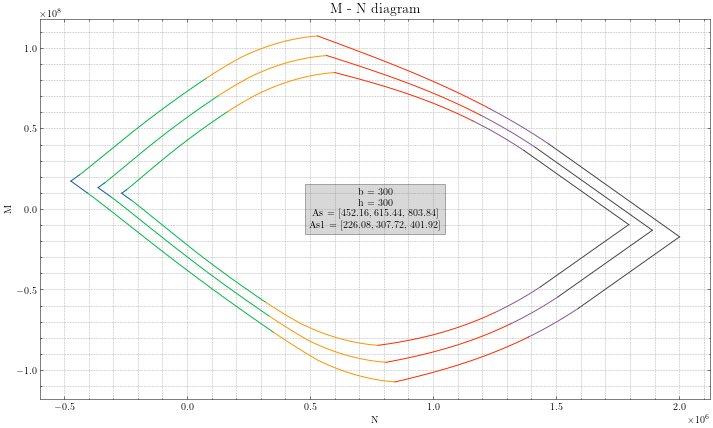

In [28]:
COLORS = [list(plt.rcParams['axes.prop_cycle'])[col]['color'] for col in range(len(list(plt.rcParams['axes.prop_cycle'])))] #colors from the matplotlib style

def interaction_diagram_single(dic_up,dic_down, NM=True,):
    x = "N" if NM else "nu"
    y = "M" if NM else "mu"

    fig, ax = plt.subplots(1,1, figsize = (12, 7))
    for i in range(1,7): 
        ax.plot(dic_up[f"{i}"][x],dic_up[f"{i}"][y],color=COLORS[i-1],label=f" Campo {i}")
        ax.plot(dic_down[f"{i}"][x],-dic_down[f"{i}"][y],color=COLORS[i-1])
        ax.set_xlabel(x) # "r"$\bf" + x + r"}$""
        ax.set_ylabel(y)
        ax.grid("True",which="both",linestyle='dashed')
        ax.set_title(f"{y} - {x} diagram", fontsize=14)
        ax.legend(loc = "best", frameon = "True")

    ax.text(
        x=0.7, 
        y=0.5, 
        s=f"b = {b}\nh = {h}\nAs   = {As} \nAs1 = {As1} ", 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes, #used to make x,y coords in global coordinates
        bbox=dict(facecolor='grey', alpha=0.3)
    )

    #plt.savefig(f"{x}_{y}_diagram.pdf")

    return fig, ax

def interaction_diagram_multiple(
        multiple_strainDistribution: create_multiple_strainDistribution, 
        NM=True,
        NM_values: list = None
    ):
    x = "N" if NM else "nu"
    y = "M" if NM else "mu"

    fig, ax = plt.subplots(1,1, figsize = (12, 7))
    ax.set_xlabel(x) # "r"$\bf" + x + r"}$""
    ax.set_ylabel(y)
    ax.grid("True",which="both",linestyle='dashed')
    ax.set_title(f"{y} - {x} diagram", fontsize=14)
    for area in range(len(multiple_strainDistribution)):
        for i in range(1,7): 
            dic_up, dic_down = multiple_strainDistribution[area]
            ax.plot(dic_up[f"{i}"][x],dic_up[f"{i}"][y],dic_down[f"{i}"][x],-dic_down[f"{i}"][y],color=COLORS[i-1])
        #ax.plot([],[], label=f"Area: {area}")    
        
    ax.text(
        x=0.5, 
        y=0.5, 
        s=f"b = {b}\nh = {h}\nAs   = {As_list} \nAs1 = {As1_list} ", 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes, #used to make x,y coords in global coordinates
        bbox=dict(facecolor='grey', alpha=0.3)
    )
    if NM_values:
        x_points = NM_values[0]
        y_points = NM_values[1]
        ax.plot(x_points, y_points,"rs")

    #plt.savefig(f"{y}_{x}_diagram_multiple.pdf")
    
    return fig, ax

#fig, ax = interaction_diagram_single(MN_up,MN_down)
fig, ax = interaction_diagram_multiple(mult, NM = True) # , NM_values=[[1,3],[2,6]]
plt.show()



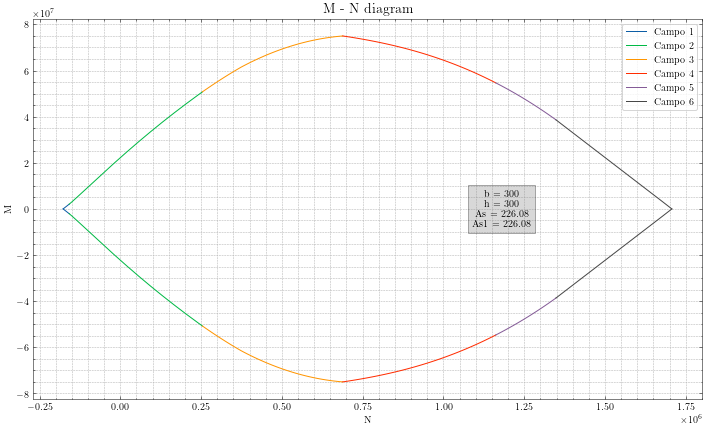

In [18]:
fig, ax = interaction_diagram_single(MN_up,MN_down, NM=True)
plt.show()

In [19]:
from dataclasses import dataclass

@dataclass
class Bars:
    n_bars: int
    diameter: int

    def a(self):
        "Area"
        return self.n_bars * 3.14 * self.diameter**2 / 4

    def __str__(self):
        "Return a string like:'2Ø4' "
        return f"{self.n_bars}Ø{self.diameter}"
   
sup = Bars(2,4)
print(sup)



2Ø4


In [20]:
stop

NameError: name 'stop' is not defined

In [ ]:
pd.DataFrame(MN_up["1"])

,N,M,nu,mu
0,-1.022478e+06,1.455065e+07,-0.440091,0.015275
1,-1.011316e+06,1.661576e+07,-0.435286,0.017443
2,-1.000024e+06,1.870477e+07,-0.430426,0.019636
3,-9.886001e+05,2.081810e+07,-0.425509,0.021855
4,-9.770430e+05,2.295618e+07,-0.420535,0.024099
5,-9.653497e+05,2.511944e+07,-0.415502,0.026370
6,-9.535178e+05,2.730833e+07,-0.410409,0.028668
7,-9.415450e+05,2.952331e+07,-0.405256,0.030993
8,-9.294285e+05,3.176485e+07,-0.400041,0.033347
9,-9.171659e+05,3.403343e+07,-0.394763,0.035728


In [ ]:
pd.DataFrame(MN_up["2"])

,N,M,nu,mu
0,-785882.290562,5.832091e+07,-0.338256,0.061225
1,-781452.008890,5.914237e+07,-0.336350,0.062087
2,-776910.577543,5.998806e+07,-0.334395,0.062975
3,-772258.282567,6.085782e+07,-0.332392,0.063888
4,-767495.420125,6.175152e+07,-0.330342,0.064826
...,...,...,...,...
125,389038.450389,2.744953e+08,0.167448,0.288164
126,394019.086495,2.752059e+08,0.169592,0.288910
127,398999.722600,2.759121e+08,0.171736,0.289651
128,403980.358706,2.766139e+08,0.173880,0.290388


In [ ]:
pd.DataFrame(MN_up["3"])

,N,M,nu,mu
0,4.089610e+05,2.773113e+08,0.176023,0.291120
1,4.162216e+05,2.782981e+08,0.179148,0.292156
2,4.234821e+05,2.792753e+08,0.182274,0.293182
3,4.307427e+05,2.802430e+08,0.185399,0.294198
4,4.380033e+05,2.812011e+08,0.188524,0.295204
...,...,...,...,...
95,1.098716e+06,3.283691e+08,0.472905,0.344720
96,1.105976e+06,3.284477e+08,0.476030,0.344803
97,1.113237e+06,3.285167e+08,0.479155,0.344875
98,1.120498e+06,3.285761e+08,0.482280,0.344938


In [ ]:
pd.DataFrame(MN_up["4"])

,N,M,nu,mu
0,1.127764e+06,3.286249e+08,0.485408,0.344989
1,1.143197e+06,3.270680e+08,0.492051,0.343354
2,1.158534e+06,3.255206e+08,0.498652,0.341730
3,1.173777e+06,3.239823e+08,0.505212,0.340115
4,1.188926e+06,3.224527e+08,0.511733,0.338509
...,...,...,...,...
95,2.310980e+06,1.954947e+08,0.994683,0.205229
96,2.321452e+06,1.940563e+08,0.999190,0.203719
97,2.331896e+06,1.926145e+08,1.003686,0.202206
98,2.342315e+06,1.911692e+08,1.008170,0.200688


In [ ]:
pd.DataFrame(MN_up["5"])

,N,M,nu,mu
0,2.352707e+06,1.897202e+08,1.012643,0.199167
1,2.358409e+06,1.889222e+08,1.015097,0.198330
2,2.364103e+06,1.881230e+08,1.017548,0.197491
3,2.369789e+06,1.873227e+08,1.019995,0.196650
4,2.375468e+06,1.865213e+08,1.022439,0.195809
5,2.381139e+06,1.857187e+08,1.024880,0.194967
6,2.386802e+06,1.849151e+08,1.027318,0.194123
7,2.392458e+06,1.841102e+08,1.029752,0.193278
8,2.398106e+06,1.833042e+08,1.032184,0.192432
9,2.403747e+06,1.824971e+08,1.034612,0.191585


In [ ]:
pd.DataFrame(MN_up["6"])

,N,M,nu,mu
0,2.623745e+06,1.491690e+08,1.129302,0.156597
1,3.053704e+06,7.681936e+07,1.314363,0.080645
2,3.200491e+06,5.140678e+07,1.377543,0.053967
3,3.286047e+06,3.649134e+07,1.414367,0.038308
4,3.341476e+06,2.677335e+07,1.438225,0.028107
...,...,...,...,...
195,3.572411e+06,-1.453986e+07,1.537623,-0.015264
196,3.572412e+06,-1.453996e+07,1.537623,-0.015264
197,3.572412e+06,-1.454007e+07,1.537624,-0.015264
198,3.572413e+06,-1.454018e+07,1.537624,-0.015264
